In [43]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [44]:
L = 4 #system size
M = 0.1 #fermion mass
N=3 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [45]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [46]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [47]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [48]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [49]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [50]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [51]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [52]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [53]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [54]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [55]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -1.04639577e-16]


In [56]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [57]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(0.04174087875417374+0.054981461684664265j)|2 2 0 1>
(-0.09432246087674495-0.12424239554805537j)|2 2 0 0>
(0.17077377916283965+0.22494476101207045j)|2 1 1 1>
(-0.045607928907875024-0.0600751749989681j)|2 1 0 1>
(-0.04174087875417445-0.054981461684664217j)|2 1 0 0>
(0.17077377916284758+0.2249447610120243j)|1 1 1 2>
(-0.46909259573929163-0.6178929948049925j)|1 1 1 1>
(0.1707737791628385+0.22494476101206998j)|1 1 0 1>
(-0.04174087875416825-0.054981461684695435j)|1 0 2 2>
(-0.045607928907888055-0.060075174998907035j)|1 0 1 2>
(0.1707737791628495+0.2249447610120257j)|1 0 1 1>
(-0.09432246087674259-0.12424239554806701j)|0 0 2 2>
(0.04174087875416687+0.05498146168469514j)|0 0 1 2>



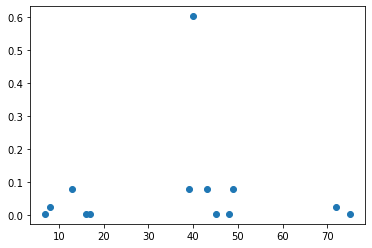

In [58]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [59]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [60]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


def ms_hamiltonian_2(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe@summe@summe
                
matrix_part_2 = ms_hamiltonian_2(1,2,0)
ms_ham_eigenval_2, ms_ham_eigenvec_2 = scipy.linalg.eigh(matrix_part_2)




def ms_gate_global_2(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_2[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_2@exponential@ms_ham_eigenvec_2.T.conj()


    
    
    
    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [61]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [62]:
def R(i,theta):
    
    if i%14 == 0:
        return(ms_gate_global(theta))

    if i%14 == 1:
        return(ms_gate_global_2(theta))
    
    if i%14 == 2:
        return(rot_sigma(3,0,1,0,theta).toarray())


    if i%14 == 3:
        return(rot_sigma(3,0,2,0,theta).toarray())

    
    if i%14 == 4:
        return(rot_sigma(3,1,2,np.pi/2,theta).toarray())
    
    
    if i%14 == 5:
        return(rot_sigma(2,0,1,0,theta).toarray())


    if i%14 == 6:
        return(rot_sigma(2,0,2,0,theta).toarray())

    
    if i%14 == 7:
        return(rot_sigma(2,1,2,np.pi/2,theta).toarray())
    

    if i%14 == 8:
        return(rot_sigma(1,0,1,0,theta).toarray())


    if i%14 == 9:
        return(rot_sigma(1,0,2,0,theta).toarray())

    
    if i%14 == 10:
        return(rot_sigma(1,1,2,np.pi/2,theta).toarray())
    
    
    if i%14 == 11:
        return(rot_sigma(0,0,1,0,theta).toarray())


    if i%14 == 12:
        return(rot_sigma(0,0,2,0,theta).toarray())

    
    if i%14 == 13:
        return(rot_sigma(0,1,2,np.pi/2,theta).toarray())
    
    
def S(i):
    
    if i%14 == 0:
        return(-1j*matrix_part)

    if i%14 == 1:
        return(-1j*matrix_part_2)

    if i%14 == 2:
        return(-1j*sigma(3,0,1,0).toarray())

    
    if i%14 == 3:
        return(-1j*sigma(3,0,2,0).toarray())

    
    if i%14 == 4:
        return(-1j*sigma(3,1,2,np.pi/2).toarray())


     
    if i%14 == 5:
        return(-1j*sigma(2,0,1,0).toarray())

    
    if i%14 == 6:
        return(-1j*sigma(2,0,2,0).toarray())

    
    if i%14 == 7:
        return(-1j*sigma(2,1,2,np.pi/2).toarray())


    if i%14 == 8:
        return(-1j*sigma(1,0,1,0).toarray())

    
    if i%14 == 9:
        return(-1j*sigma(1,0,2,0).toarray())

    
    if i%14 == 10:
        return(-1j*sigma(1,1,2,np.pi/2).toarray())

     
    if i%14 == 11:
        return(-1j*sigma(0,0,1,0).toarray())

    
    if i%14 == 12:
        return(-1j*sigma(0,0,2,0).toarray())

    
    if i%14 == 13:
        return(-1j*sigma(0,1,2,np.pi/2).toarray())

In [63]:
coeff = 14

In [64]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]


In [65]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [66]:
stepp = 1000
t_final = 10

In [67]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [68]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [69]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)


2022-07-22 16:25:39.618755
2022-07-22 16:25:40.115510
0
2022-07-22 16:25:40.116900
2022-07-22 16:25:40.601409
0.005
2022-07-22 16:25:40.602794
2022-07-22 16:25:41.098721
0.005
2022-07-22 16:25:41.100385
2022-07-22 16:25:41.585531
0.01
2022-07-22 16:25:41.587215
2022-07-22 16:25:42.089720
0.01
2022-07-22 16:25:42.091412
2022-07-22 16:25:42.599006
0.015
2022-07-22 16:25:42.600425
2022-07-22 16:25:43.090032
0.015
2022-07-22 16:25:43.091775
2022-07-22 16:25:43.573611
0.02
2022-07-22 16:25:43.575001
2022-07-22 16:25:44.059863
0.02
2022-07-22 16:25:44.063232
2022-07-22 16:25:44.542933
0.025
2022-07-22 16:25:44.544671
2022-07-22 16:25:45.077829
0.025
2022-07-22 16:25:45.079403
2022-07-22 16:25:45.591299
0.03
2022-07-22 16:25:45.592992
2022-07-22 16:25:46.073475
0.03
2022-07-22 16:25:46.075061
2022-07-22 16:25:46.634449
0.034999999999999996
2022-07-22 16:25:46.636342
2022-07-22 16:25:47.204289
0.034999999999999996
2022-07-22 16:25:47.206147
2022-07-22 16:25:47.737110
0.04
2022-07-22 16:25:47.7

2022-07-22 16:26:53.337958
0.3000000000000001
2022-07-22 16:26:53.339606
2022-07-22 16:26:53.945299
0.3050000000000001
2022-07-22 16:26:53.946993
2022-07-22 16:26:54.543196
0.3050000000000001
2022-07-22 16:26:54.544973
2022-07-22 16:26:55.139529
0.3100000000000001
2022-07-22 16:26:55.141455
2022-07-22 16:26:55.728801
0.3100000000000001
2022-07-22 16:26:55.730717
2022-07-22 16:26:56.323448
0.3150000000000001
2022-07-22 16:26:56.325113
2022-07-22 16:26:56.921005
0.3150000000000001
2022-07-22 16:26:56.922771
2022-07-22 16:26:57.514628
0.3200000000000001
2022-07-22 16:26:57.516641
2022-07-22 16:26:58.111287
0.3200000000000001
2022-07-22 16:26:58.112909
2022-07-22 16:26:58.708544
0.3250000000000001
2022-07-22 16:26:58.710317
2022-07-22 16:26:59.302471
0.3250000000000001
2022-07-22 16:26:59.304107
2022-07-22 16:26:59.900425
0.3300000000000001
2022-07-22 16:26:59.902878
2022-07-22 16:27:00.670133
0.3300000000000001
2022-07-22 16:27:00.672293
2022-07-22 16:27:01.432928
0.33500000000000013
2022

2022-07-22 16:28:06.140161
0.5800000000000003
2022-07-22 16:28:06.142092
2022-07-22 16:28:06.744505
0.5850000000000003
2022-07-22 16:28:06.746745
2022-07-22 16:28:07.360641
0.5850000000000003
2022-07-22 16:28:07.362842
2022-07-22 16:28:07.968438
0.5900000000000003
2022-07-22 16:28:07.970635
2022-07-22 16:28:08.576961
0.5900000000000003
2022-07-22 16:28:08.578892
2022-07-22 16:28:09.189747
0.5950000000000003
2022-07-22 16:28:09.191420
2022-07-22 16:28:09.798918
0.5950000000000003
2022-07-22 16:28:09.800741
2022-07-22 16:28:10.413177
0.6000000000000003
2022-07-22 16:28:10.415100
2022-07-22 16:28:11.025487
0.6000000000000003
2022-07-22 16:28:11.027515
2022-07-22 16:28:11.632072
0.6050000000000003
2022-07-22 16:28:11.633789
2022-07-22 16:28:12.253129
0.6050000000000003
2022-07-22 16:28:12.254728
2022-07-22 16:28:12.861274
0.6100000000000003
2022-07-22 16:28:12.863555
2022-07-22 16:28:13.473858
0.6100000000000003
2022-07-22 16:28:13.476113
2022-07-22 16:28:14.089275
0.6150000000000003
2022-

2022-07-22 16:29:15.597969
0.8650000000000005
2022-07-22 16:29:15.599656
2022-07-22 16:29:16.214741
0.8650000000000005
2022-07-22 16:29:16.216758
2022-07-22 16:29:16.830103
0.8700000000000006
2022-07-22 16:29:16.832368
2022-07-22 16:29:17.447089
0.8700000000000006
2022-07-22 16:29:17.448920
2022-07-22 16:29:18.064494
0.8750000000000006
2022-07-22 16:29:18.066171
2022-07-22 16:29:18.680068
0.8750000000000006
2022-07-22 16:29:18.682272
2022-07-22 16:29:19.300077
0.8800000000000006
2022-07-22 16:29:19.302032
2022-07-22 16:29:19.918019
0.8800000000000006
2022-07-22 16:29:19.919704
2022-07-22 16:29:20.532030
0.8850000000000006
2022-07-22 16:29:20.533635
2022-07-22 16:29:21.150920
0.8850000000000006
2022-07-22 16:29:21.152726
2022-07-22 16:29:21.768425
0.8900000000000006
2022-07-22 16:29:21.770661
2022-07-22 16:29:22.390881
0.8900000000000006
2022-07-22 16:29:22.392835
2022-07-22 16:29:23.006844
0.8950000000000006
2022-07-22 16:29:23.009060
2022-07-22 16:29:23.624282
0.8950000000000006
2022-

2022-07-22 16:30:30.295838
1.1450000000000007
2022-07-22 16:30:30.298453
2022-07-22 16:30:30.972094
1.1500000000000008
2022-07-22 16:30:30.974190
2022-07-22 16:30:31.646115
1.1500000000000008
2022-07-22 16:30:31.648555
2022-07-22 16:30:32.343196
1.1550000000000007
2022-07-22 16:30:32.345110
2022-07-22 16:30:32.987565
1.1550000000000007
2022-07-22 16:30:32.989569
2022-07-22 16:30:33.610906
1.1600000000000008
2022-07-22 16:30:33.612672
2022-07-22 16:30:34.277193
1.1600000000000008
2022-07-22 16:30:34.279265
2022-07-22 16:30:34.998492
1.1650000000000007
2022-07-22 16:30:35.000581
2022-07-22 16:30:35.667451
1.1650000000000007
2022-07-22 16:30:35.669747
2022-07-22 16:30:36.338264
1.1700000000000008
2022-07-22 16:30:36.341084
2022-07-22 16:30:37.025129
1.1700000000000008
2022-07-22 16:30:37.027099
2022-07-22 16:30:37.704531
1.1750000000000007
2022-07-22 16:30:37.706769
2022-07-22 16:30:38.398018
1.1750000000000007
2022-07-22 16:30:38.399888
2022-07-22 16:30:39.058741
1.1800000000000008
2022-

2022-07-22 16:31:49.674305
1.430000000000001
2022-07-22 16:31:49.676568
2022-07-22 16:31:50.434609
1.430000000000001
2022-07-22 16:31:50.437000
2022-07-22 16:31:51.246237
1.435000000000001
2022-07-22 16:31:51.247946
2022-07-22 16:31:51.984011
1.435000000000001
2022-07-22 16:31:51.985668
2022-07-22 16:31:52.724006
1.440000000000001
2022-07-22 16:31:52.725998
2022-07-22 16:31:53.452054
1.440000000000001
2022-07-22 16:31:53.454275
2022-07-22 16:31:54.178278
1.445000000000001
2022-07-22 16:31:54.180061
2022-07-22 16:31:54.908782
1.445000000000001
2022-07-22 16:31:54.911473
2022-07-22 16:31:55.648296
1.450000000000001
2022-07-22 16:31:55.650265
2022-07-22 16:31:56.356893
1.450000000000001
2022-07-22 16:31:56.358961
2022-07-22 16:31:57.087309
1.455000000000001
2022-07-22 16:31:57.089389
2022-07-22 16:31:57.823080
1.455000000000001
2022-07-22 16:31:57.824916
2022-07-22 16:31:58.572763
1.460000000000001
2022-07-22 16:31:58.574868
2022-07-22 16:31:59.395785
1.460000000000001
2022-07-22 16:31:59

2022-07-22 16:33:14.454943
1.7100000000000013
2022-07-22 16:33:14.457660
2022-07-22 16:33:15.390048
1.7150000000000012
2022-07-22 16:33:15.392512
2022-07-22 16:33:16.267906
1.7150000000000012
2022-07-22 16:33:16.269925
2022-07-22 16:33:17.010132
1.7200000000000013
2022-07-22 16:33:17.012007
2022-07-22 16:33:17.746575
1.7200000000000013
2022-07-22 16:33:17.748891
2022-07-22 16:33:18.487779
1.7250000000000012
2022-07-22 16:33:18.489899
2022-07-22 16:33:19.213039
1.7250000000000012
2022-07-22 16:33:19.215141
2022-07-22 16:33:19.983870
1.7300000000000013
2022-07-22 16:33:19.985962
2022-07-22 16:33:20.753784
1.7300000000000013
2022-07-22 16:33:20.756259
2022-07-22 16:33:21.532892
1.7350000000000012
2022-07-22 16:33:21.535504
2022-07-22 16:33:22.296429
1.7350000000000012
2022-07-22 16:33:22.298524
2022-07-22 16:33:23.027197
1.7400000000000013
2022-07-22 16:33:23.029068
2022-07-22 16:33:23.763022
1.7400000000000013
2022-07-22 16:33:23.765594
2022-07-22 16:33:24.488647
1.7450000000000012
2022-

2022-07-22 16:34:31.021948
1.9950000000000014
2022-07-22 16:34:31.023695
2022-07-22 16:34:31.651772
1.9950000000000014
2022-07-22 16:34:31.653687
2022-07-22 16:34:32.278818
2.0000000000000013
2022-07-22 16:34:32.280786
2022-07-22 16:34:32.905014
2.0000000000000013
2022-07-22 16:34:32.908126
2022-07-22 16:34:33.537876
2.0050000000000012
2022-07-22 16:34:33.539563
2022-07-22 16:34:34.172317
2.0050000000000012
2022-07-22 16:34:34.173997
2022-07-22 16:34:34.797775
2.010000000000001
2022-07-22 16:34:34.799998
2022-07-22 16:34:35.433691
2.010000000000001
2022-07-22 16:34:35.435856
2022-07-22 16:34:36.061931
2.015000000000001
2022-07-22 16:34:36.063650
2022-07-22 16:34:36.689354
2.015000000000001
2022-07-22 16:34:36.691275
2022-07-22 16:34:37.314864
2.020000000000001
2022-07-22 16:34:37.317105
2022-07-22 16:34:37.941257
2.020000000000001
2022-07-22 16:34:37.943475
2022-07-22 16:34:38.568502
2.025000000000001
2022-07-22 16:34:38.570232
2022-07-22 16:34:39.195746
2.025000000000001
2022-07-22 16

2022-07-22 16:35:43.615054
2.2799999999999954
2022-07-22 16:35:43.617021
2022-07-22 16:35:44.242558
2.2849999999999953
2022-07-22 16:35:44.244308
2022-07-22 16:35:44.870347
2.2849999999999953
2022-07-22 16:35:44.872287
2022-07-22 16:35:45.495311
2.289999999999995
2022-07-22 16:35:45.497229
2022-07-22 16:35:46.131622
2.289999999999995
2022-07-22 16:35:46.133618
2022-07-22 16:35:46.765009
2.294999999999995
2022-07-22 16:35:46.766830
2022-07-22 16:35:47.391059
2.294999999999995
2022-07-22 16:35:47.393239
2022-07-22 16:35:48.015462
2.299999999999995
2022-07-22 16:35:48.017335
2022-07-22 16:35:48.644076
2.299999999999995
2022-07-22 16:35:48.646422
2022-07-22 16:35:49.275223
2.304999999999995
2022-07-22 16:35:49.276868
2022-07-22 16:35:49.900253
2.304999999999995
2022-07-22 16:35:49.902232
2022-07-22 16:35:50.530284
2.3099999999999947
2022-07-22 16:35:50.532000
2022-07-22 16:35:51.164849
2.3099999999999947
2022-07-22 16:35:51.166474
2022-07-22 16:35:51.793975
2.3149999999999946
2022-07-22 16

2022-07-22 16:36:55.419983
2.5649999999999893
2022-07-22 16:36:55.422202
2022-07-22 16:36:56.066145
2.569999999999989
2022-07-22 16:36:56.067933
2022-07-22 16:36:56.692823
2.569999999999989
2022-07-22 16:36:56.694704
2022-07-22 16:36:57.323549
2.574999999999989
2022-07-22 16:36:57.325461
2022-07-22 16:36:57.950850
2.574999999999989
2022-07-22 16:36:57.953042
2022-07-22 16:36:58.578155
2.579999999999989
2022-07-22 16:36:58.579927
2022-07-22 16:36:59.203678
2.579999999999989
2022-07-22 16:36:59.205724
2022-07-22 16:36:59.830309
2.584999999999989
2022-07-22 16:36:59.832226
2022-07-22 16:37:00.463713
2.584999999999989
2022-07-22 16:37:00.465686
2022-07-22 16:37:01.093822
2.5899999999999888
2022-07-22 16:37:01.095799
2022-07-22 16:37:01.724256
2.5899999999999888
2022-07-22 16:37:01.725947
2022-07-22 16:37:02.359277
2.5949999999999886
2022-07-22 16:37:02.361220
2022-07-22 16:37:02.987219
2.5949999999999886
2022-07-22 16:37:02.989038
2022-07-22 16:37:03.613744
2.5999999999999885
2022-07-22 16

2022-07-22 16:38:06.649022
2.849999999999983
2022-07-22 16:38:06.651180
2022-07-22 16:38:07.277848
2.849999999999983
2022-07-22 16:38:07.279813
2022-07-22 16:38:07.902345
2.854999999999983
2022-07-22 16:38:07.904132
2022-07-22 16:38:08.530641
2.854999999999983
2022-07-22 16:38:08.532353
2022-07-22 16:38:09.159101
2.859999999999983
2022-07-22 16:38:09.161127
2022-07-22 16:38:09.783784
2.859999999999983
2022-07-22 16:38:09.785589
2022-07-22 16:38:10.417194
2.864999999999983
2022-07-22 16:38:10.419015
2022-07-22 16:38:11.063935
2.864999999999983
2022-07-22 16:38:11.065670
2022-07-22 16:38:11.686407
2.869999999999983
2022-07-22 16:38:11.688215
2022-07-22 16:38:12.325748
2.869999999999983
2022-07-22 16:38:12.327808
2022-07-22 16:38:12.962026
2.8749999999999827
2022-07-22 16:38:12.964004
2022-07-22 16:38:13.597939
2.8749999999999827
2022-07-22 16:38:13.599863
2022-07-22 16:38:14.227403
2.8799999999999826
2022-07-22 16:38:14.229178
2022-07-22 16:38:14.849526
2.8799999999999826
2022-07-22 16:3

2022-07-22 16:39:18.289248
3.134999999999977
2022-07-22 16:39:18.290985
2022-07-22 16:39:18.918280
3.134999999999977
2022-07-22 16:39:18.920177
2022-07-22 16:39:19.542046
3.139999999999977
2022-07-22 16:39:19.544038
2022-07-22 16:39:20.171405
3.139999999999977
2022-07-22 16:39:20.173358
2022-07-22 16:39:20.796794
3.144999999999977
2022-07-22 16:39:20.798586
2022-07-22 16:39:21.429262
3.144999999999977
2022-07-22 16:39:21.431507
2022-07-22 16:39:22.059643
3.149999999999977
2022-07-22 16:39:22.061328
2022-07-22 16:39:22.681536
3.149999999999977
2022-07-22 16:39:22.683203
2022-07-22 16:39:23.313087
3.1549999999999767
2022-07-22 16:39:23.314976
2022-07-22 16:39:23.942441
3.1549999999999767
2022-07-22 16:39:23.944177
2022-07-22 16:39:24.564861
3.1599999999999766
2022-07-22 16:39:24.566956
2022-07-22 16:39:25.194051
3.1599999999999766
2022-07-22 16:39:25.196010
2022-07-22 16:39:25.814793
3.1649999999999765
2022-07-22 16:39:25.816466
2022-07-22 16:39:26.496989
3.1649999999999765
2022-07-22 16

2022-07-22 16:40:32.042961
3.414999999999971
2022-07-22 16:40:32.045547
2022-07-22 16:40:32.783084
3.419999999999971
2022-07-22 16:40:32.785085
2022-07-22 16:40:33.516051
3.419999999999971
2022-07-22 16:40:33.518062
2022-07-22 16:40:34.247379
3.424999999999971
2022-07-22 16:40:34.249390
2022-07-22 16:40:34.945542
3.424999999999971
2022-07-22 16:40:34.947576
2022-07-22 16:40:35.623715
3.429999999999971
2022-07-22 16:40:35.625550
2022-07-22 16:40:36.257410
3.429999999999971
2022-07-22 16:40:36.259345
2022-07-22 16:40:36.870577
3.4349999999999707
2022-07-22 16:40:36.872630
2022-07-22 16:40:37.486823
3.4349999999999707
2022-07-22 16:40:37.488490
2022-07-22 16:40:38.099341
3.4399999999999706
2022-07-22 16:40:38.101031
2022-07-22 16:40:38.712322
3.4399999999999706
2022-07-22 16:40:38.714551
2022-07-22 16:40:39.328254
3.4449999999999705
2022-07-22 16:40:39.330050
2022-07-22 16:40:39.949554
3.4449999999999705
2022-07-22 16:40:39.951171
2022-07-22 16:40:40.569900
3.4499999999999704
2022-07-22 1

2022-07-22 16:41:47.891592
3.699999999999965
2022-07-22 16:41:47.893358
2022-07-22 16:41:48.517653
3.704999999999965
2022-07-22 16:41:48.519641
2022-07-22 16:41:49.152370
3.704999999999965
2022-07-22 16:41:49.154042
2022-07-22 16:41:49.777094
3.709999999999965
2022-07-22 16:41:49.778777
2022-07-22 16:41:50.409510
3.709999999999965
2022-07-22 16:41:50.411231
2022-07-22 16:41:51.040440
3.7149999999999648
2022-07-22 16:41:51.042128
2022-07-22 16:41:51.659860
3.7149999999999648
2022-07-22 16:41:51.661764
2022-07-22 16:41:52.287723
3.7199999999999647
2022-07-22 16:41:52.289770
2022-07-22 16:41:52.916576
3.7199999999999647
2022-07-22 16:41:52.918488
2022-07-22 16:41:53.538495
3.7249999999999646
2022-07-22 16:41:53.540467
2022-07-22 16:41:54.166284
3.7249999999999646
2022-07-22 16:41:54.168079
2022-07-22 16:41:54.786869
3.7299999999999645
2022-07-22 16:41:54.788714
2022-07-22 16:41:55.421419
3.7299999999999645
2022-07-22 16:41:55.423020
2022-07-22 16:41:56.053541
3.7349999999999643
2022-07-22

2022-07-22 16:42:59.947090
3.984999999999959
2022-07-22 16:42:59.949066
2022-07-22 16:43:00.582999
3.989999999999959
2022-07-22 16:43:00.584909
2022-07-22 16:43:01.217004
3.989999999999959
2022-07-22 16:43:01.219229
2022-07-22 16:43:01.853681
3.994999999999959
2022-07-22 16:43:01.855490
2022-07-22 16:43:02.494392
3.994999999999959
2022-07-22 16:43:02.496298
2022-07-22 16:43:03.127341
3.9999999999999587
2022-07-22 16:43:03.129308
2022-07-22 16:43:03.771790
3.9999999999999587
2022-07-22 16:43:03.773619
2022-07-22 16:43:04.399326
4.004999999999959
2022-07-22 16:43:04.401239
2022-07-22 16:43:05.029576
4.004999999999959
2022-07-22 16:43:05.031359
2022-07-22 16:43:05.660479
4.009999999999959
2022-07-22 16:43:05.662166
2022-07-22 16:43:06.295659
4.009999999999959
2022-07-22 16:43:06.297366
2022-07-22 16:43:06.930317
4.014999999999959
2022-07-22 16:43:06.932066
2022-07-22 16:43:07.571890
4.014999999999959
2022-07-22 16:43:07.573804
2022-07-22 16:43:08.207158
4.019999999999959
2022-07-22 16:43:

2022-07-22 16:44:12.004225
4.269999999999953
2022-07-22 16:44:12.006215
2022-07-22 16:44:12.630039
4.274999999999953
2022-07-22 16:44:12.631798
2022-07-22 16:44:13.259262
4.274999999999953
2022-07-22 16:44:13.260972
2022-07-22 16:44:13.886816
4.279999999999953
2022-07-22 16:44:13.888800
2022-07-22 16:44:14.513301
4.279999999999953
2022-07-22 16:44:14.515578
2022-07-22 16:44:15.144717
4.284999999999953
2022-07-22 16:44:15.146693
2022-07-22 16:44:15.785272
4.284999999999953
2022-07-22 16:44:15.787225
2022-07-22 16:44:16.412144
4.289999999999953
2022-07-22 16:44:16.413795
2022-07-22 16:44:17.041051
4.289999999999953
2022-07-22 16:44:17.042993
2022-07-22 16:44:17.673431
4.294999999999953
2022-07-22 16:44:17.675293
2022-07-22 16:44:18.303092
4.294999999999953
2022-07-22 16:44:18.304903
2022-07-22 16:44:18.928328
4.299999999999953
2022-07-22 16:44:18.930014
2022-07-22 16:44:19.554269
4.299999999999953
2022-07-22 16:44:19.556188
2022-07-22 16:44:20.184222
4.304999999999953
2022-07-22 16:44:20

2022-07-22 16:45:23.703743
4.554999999999947
2022-07-22 16:45:23.705624
2022-07-22 16:45:24.334821
4.559999999999947
2022-07-22 16:45:24.336539
2022-07-22 16:45:24.959385
4.559999999999947
2022-07-22 16:45:24.961308
2022-07-22 16:45:25.587610
4.564999999999947
2022-07-22 16:45:25.589586
2022-07-22 16:45:26.230200
4.564999999999947
2022-07-22 16:45:26.231951
2022-07-22 16:45:26.957909
4.569999999999947
2022-07-22 16:45:26.959692
2022-07-22 16:45:27.600162
4.569999999999947
2022-07-22 16:45:27.601950
2022-07-22 16:45:28.235172
4.574999999999947
2022-07-22 16:45:28.237114
2022-07-22 16:45:28.885737
4.574999999999947
2022-07-22 16:45:28.887622
2022-07-22 16:45:29.517079
4.579999999999947
2022-07-22 16:45:29.518784
2022-07-22 16:45:30.141831
4.579999999999947
2022-07-22 16:45:30.143445
2022-07-22 16:45:30.777372
4.584999999999947
2022-07-22 16:45:30.779311
2022-07-22 16:45:31.404616
4.584999999999947
2022-07-22 16:45:31.406569
2022-07-22 16:45:32.036162
4.589999999999947
2022-07-22 16:45:32

2022-07-22 16:46:35.375183
4.839999999999941
2022-07-22 16:46:35.377172
2022-07-22 16:46:36.002749
4.844999999999941
2022-07-22 16:46:36.005026
2022-07-22 16:46:36.633999
4.844999999999941
2022-07-22 16:46:36.635728
2022-07-22 16:46:37.256701
4.849999999999941
2022-07-22 16:46:37.258806
2022-07-22 16:46:37.882526
4.849999999999941
2022-07-22 16:46:37.884643
2022-07-22 16:46:38.504885
4.854999999999941
2022-07-22 16:46:38.506684
2022-07-22 16:46:39.130415
4.854999999999941
2022-07-22 16:46:39.132110
2022-07-22 16:46:39.753111
4.859999999999941
2022-07-22 16:46:39.754899
2022-07-22 16:46:40.376368
4.859999999999941
2022-07-22 16:46:40.378335
2022-07-22 16:46:41.000823
4.864999999999941
2022-07-22 16:46:41.002498
2022-07-22 16:46:41.621505
4.864999999999941
2022-07-22 16:46:41.623302
2022-07-22 16:46:42.246577
4.869999999999941
2022-07-22 16:46:42.248387
2022-07-22 16:46:42.878120
4.869999999999941
2022-07-22 16:46:42.879925
2022-07-22 16:46:43.502057
4.8749999999999405
2022-07-22 16:46:4

2022-07-22 16:47:48.558381
5.124999999999935
2022-07-22 16:47:48.560181
2022-07-22 16:47:49.187127
5.129999999999935
2022-07-22 16:47:49.189040
2022-07-22 16:47:49.811628
5.129999999999935
2022-07-22 16:47:49.813488
2022-07-22 16:47:50.435279
5.134999999999935
2022-07-22 16:47:50.437574
2022-07-22 16:47:51.062894
5.134999999999935
2022-07-22 16:47:51.065119
2022-07-22 16:47:51.689304
5.139999999999935
2022-07-22 16:47:51.691571
2022-07-22 16:47:52.315127
5.139999999999935
2022-07-22 16:47:52.316936
2022-07-22 16:47:52.953676
5.144999999999935
2022-07-22 16:47:52.955497
2022-07-22 16:47:53.579971
5.144999999999935
2022-07-22 16:47:53.582052
2022-07-22 16:47:54.205345
5.149999999999935
2022-07-22 16:47:54.207545
2022-07-22 16:47:54.834613
5.149999999999935
2022-07-22 16:47:54.836681
2022-07-22 16:47:55.462227
5.1549999999999345
2022-07-22 16:47:55.464467
2022-07-22 16:47:56.091934
5.1549999999999345
2022-07-22 16:47:56.093887
2022-07-22 16:47:56.720229
5.159999999999934
2022-07-22 16:47:

2022-07-22 16:49:00.286176
5.409999999999929
2022-07-22 16:49:00.288376
2022-07-22 16:49:00.913726
5.414999999999929
2022-07-22 16:49:00.915591
2022-07-22 16:49:01.542967
5.414999999999929
2022-07-22 16:49:01.544673
2022-07-22 16:49:02.173694
5.419999999999929
2022-07-22 16:49:02.175333
2022-07-22 16:49:02.800954
5.419999999999929
2022-07-22 16:49:02.802569
2022-07-22 16:49:03.424600
5.424999999999929
2022-07-22 16:49:03.426290
2022-07-22 16:49:04.051295
5.424999999999929
2022-07-22 16:49:04.053200
2022-07-22 16:49:04.675407
5.429999999999929
2022-07-22 16:49:04.677178
2022-07-22 16:49:05.303644
5.429999999999929
2022-07-22 16:49:05.305466
2022-07-22 16:49:05.927354
5.4349999999999286
2022-07-22 16:49:05.929180
2022-07-22 16:49:06.552117
5.4349999999999286
2022-07-22 16:49:06.553914
2022-07-22 16:49:07.176351
5.4399999999999284
2022-07-22 16:49:07.178264
2022-07-22 16:49:07.801910
5.4399999999999284
2022-07-22 16:49:07.803880
2022-07-22 16:49:08.430949
5.444999999999928
2022-07-22 16:4

2022-07-22 16:50:12.116835
5.694999999999923
2022-07-22 16:50:12.118825
2022-07-22 16:50:12.742024
5.699999999999923
2022-07-22 16:50:12.743821
2022-07-22 16:50:13.373029
5.699999999999923
2022-07-22 16:50:13.374827
2022-07-22 16:50:14.001864
5.704999999999923
2022-07-22 16:50:14.003666
2022-07-22 16:50:14.627484
5.704999999999923
2022-07-22 16:50:14.629163
2022-07-22 16:50:15.253682
5.709999999999923
2022-07-22 16:50:15.255577
2022-07-22 16:50:15.879647
5.709999999999923
2022-07-22 16:50:15.881627
2022-07-22 16:50:16.511892
5.714999999999923
2022-07-22 16:50:16.513596
2022-07-22 16:50:17.137485
5.714999999999923
2022-07-22 16:50:17.139431
2022-07-22 16:50:17.767355
5.7199999999999225
2022-07-22 16:50:17.769196
2022-07-22 16:50:18.399461
5.7199999999999225
2022-07-22 16:50:18.401791
2022-07-22 16:50:19.035309
5.724999999999922
2022-07-22 16:50:19.037115
2022-07-22 16:50:19.683489
5.724999999999922
2022-07-22 16:50:19.685453
2022-07-22 16:50:20.307999
5.729999999999922
2022-07-22 16:50:

2022-07-22 16:51:23.810201
5.979999999999917
2022-07-22 16:51:23.811815
2022-07-22 16:51:24.446142
5.984999999999917
2022-07-22 16:51:24.448093
2022-07-22 16:51:25.072206
5.984999999999917
2022-07-22 16:51:25.073810
2022-07-22 16:51:25.704744
5.989999999999917
2022-07-22 16:51:25.706589
2022-07-22 16:51:26.384407
5.989999999999917
2022-07-22 16:51:26.386624
2022-07-22 16:51:27.070840
5.994999999999917
2022-07-22 16:51:27.072911
2022-07-22 16:51:27.712626
5.994999999999917
2022-07-22 16:51:27.714501
2022-07-22 16:51:28.355455
5.9999999999999165
2022-07-22 16:51:28.357359
2022-07-22 16:51:28.998845
5.9999999999999165
2022-07-22 16:51:29.000743
2022-07-22 16:51:29.626617
6.004999999999916
2022-07-22 16:51:29.628819
2022-07-22 16:51:30.254492
6.004999999999916
2022-07-22 16:51:30.256388
2022-07-22 16:51:30.882243
6.009999999999916
2022-07-22 16:51:30.884021
2022-07-22 16:51:31.509101
6.009999999999916
2022-07-22 16:51:31.511559
2022-07-22 16:51:32.143327
6.014999999999916
2022-07-22 16:51:

2022-07-22 16:52:35.987578
6.264999999999911
2022-07-22 16:52:35.989244
2022-07-22 16:52:36.612348
6.269999999999911
2022-07-22 16:52:36.614506
2022-07-22 16:52:37.235396
6.269999999999911
2022-07-22 16:52:37.237281
2022-07-22 16:52:37.863293
6.274999999999911
2022-07-22 16:52:37.865190
2022-07-22 16:52:38.490989
6.274999999999911
2022-07-22 16:52:38.492950
2022-07-22 16:52:39.115143
6.2799999999999105
2022-07-22 16:52:39.116896
2022-07-22 16:52:39.741376
6.2799999999999105
2022-07-22 16:52:39.743233
2022-07-22 16:52:40.366568
6.28499999999991
2022-07-22 16:52:40.368952
2022-07-22 16:52:40.999848
6.28499999999991
2022-07-22 16:52:41.001959
2022-07-22 16:52:41.627732
6.28999999999991
2022-07-22 16:52:41.629683
2022-07-22 16:52:42.253487
6.28999999999991
2022-07-22 16:52:42.255665
2022-07-22 16:52:42.883539
6.29499999999991
2022-07-22 16:52:42.885442
2022-07-22 16:52:43.506744
6.29499999999991
2022-07-22 16:52:43.508745
2022-07-22 16:52:44.132139
6.29999999999991
2022-07-22 16:52:44.1338

2022-07-22 16:53:47.753706
6.549999999999905
2022-07-22 16:53:47.755668
2022-07-22 16:53:48.385303
6.554999999999905
2022-07-22 16:53:48.387016
2022-07-22 16:53:49.015229
6.554999999999905
2022-07-22 16:53:49.016933
2022-07-22 16:53:49.664237
6.559999999999905
2022-07-22 16:53:49.666259
2022-07-22 16:53:50.293917
6.559999999999905
2022-07-22 16:53:50.296016
2022-07-22 16:53:50.920911
6.5649999999999045
2022-07-22 16:53:50.922804
2022-07-22 16:53:51.545852
6.5649999999999045
2022-07-22 16:53:51.547587
2022-07-22 16:53:52.195199
6.569999999999904
2022-07-22 16:53:52.196890
2022-07-22 16:53:52.816544
6.569999999999904
2022-07-22 16:53:52.818732
2022-07-22 16:53:53.443922
6.574999999999904
2022-07-22 16:53:53.445882
2022-07-22 16:53:54.071303
6.574999999999904
2022-07-22 16:53:54.073266
2022-07-22 16:53:54.699400
6.579999999999904
2022-07-22 16:53:54.701277
2022-07-22 16:53:55.334417
6.579999999999904
2022-07-22 16:53:55.336222
2022-07-22 16:53:55.961577
6.584999999999904
2022-07-22 16:53:

2022-07-22 16:55:00.421990
6.839999999999899
2022-07-22 16:55:00.423721
2022-07-22 16:55:01.052347
6.839999999999899
2022-07-22 16:55:01.054230
2022-07-22 16:55:01.682610
6.8449999999998985
2022-07-22 16:55:01.684323
2022-07-22 16:55:02.312605
6.8449999999998985
2022-07-22 16:55:02.314300
2022-07-22 16:55:02.944709
6.849999999999898
2022-07-22 16:55:02.946516
2022-07-22 16:55:03.579709
6.849999999999898
2022-07-22 16:55:03.581485
2022-07-22 16:55:04.221428
6.854999999999898
2022-07-22 16:55:04.223380
2022-07-22 16:55:04.851866
6.854999999999898
2022-07-22 16:55:04.853772
2022-07-22 16:55:05.481321
6.859999999999898
2022-07-22 16:55:05.483014
2022-07-22 16:55:06.109720
6.859999999999898
2022-07-22 16:55:06.111870
2022-07-22 16:55:06.759319
6.864999999999898
2022-07-22 16:55:06.761107
2022-07-22 16:55:07.386320
6.864999999999898
2022-07-22 16:55:07.388221
2022-07-22 16:55:08.013840
6.869999999999898
2022-07-22 16:55:08.015836
2022-07-22 16:55:08.644907
6.869999999999898
2022-07-22 16:55:

2022-07-22 16:56:12.638252
7.1249999999998925
2022-07-22 16:56:12.639865
2022-07-22 16:56:13.269801
7.1249999999998925
2022-07-22 16:56:13.271608
2022-07-22 16:56:13.896491
7.129999999999892
2022-07-22 16:56:13.898715
2022-07-22 16:56:14.525234
7.129999999999892
2022-07-22 16:56:14.527039
2022-07-22 16:56:15.163165
7.134999999999892
2022-07-22 16:56:15.164875
2022-07-22 16:56:15.789498
7.134999999999892
2022-07-22 16:56:15.791357
2022-07-22 16:56:16.419137
7.139999999999892
2022-07-22 16:56:16.421107
2022-07-22 16:56:17.043209
7.139999999999892
2022-07-22 16:56:17.045370
2022-07-22 16:56:17.674694
7.144999999999892
2022-07-22 16:56:17.676393
2022-07-22 16:56:18.303745
7.144999999999892
2022-07-22 16:56:18.305957
2022-07-22 16:56:18.939962
7.149999999999892
2022-07-22 16:56:18.941839
2022-07-22 16:56:19.574663
7.149999999999892
2022-07-22 16:56:19.576637
2022-07-22 16:56:20.206718
7.154999999999892
2022-07-22 16:56:20.208661
2022-07-22 16:56:20.840347
7.154999999999892
2022-07-22 16:56:

2022-07-22 16:57:24.607429
7.4099999999998865
2022-07-22 16:57:24.609234
2022-07-22 16:57:25.238173
7.4099999999998865
2022-07-22 16:57:25.240210
2022-07-22 16:57:25.865146
7.414999999999886
2022-07-22 16:57:25.867303
2022-07-22 16:57:26.561876
7.414999999999886
2022-07-22 16:57:26.563765
2022-07-22 16:57:27.227787
7.419999999999886
2022-07-22 16:57:27.229579
2022-07-22 16:57:27.872146
7.419999999999886
2022-07-22 16:57:27.873866
2022-07-22 16:57:28.512842
7.424999999999886
2022-07-22 16:57:28.514904
2022-07-22 16:57:29.160939
7.424999999999886
2022-07-22 16:57:29.163031
2022-07-22 16:57:29.794861
7.429999999999886
2022-07-22 16:57:29.796841
2022-07-22 16:57:30.426374
7.429999999999886
2022-07-22 16:57:30.427981
2022-07-22 16:57:31.053230
7.434999999999886
2022-07-22 16:57:31.054837
2022-07-22 16:57:31.686677
7.434999999999886
2022-07-22 16:57:31.688451
2022-07-22 16:57:32.314118
7.439999999999886
2022-07-22 16:57:32.315903
2022-07-22 16:57:32.944800
7.439999999999886
2022-07-22 16:57:

2022-07-22 16:58:36.717352
7.69499999999988
2022-07-22 16:58:36.719499
2022-07-22 16:58:37.346805
7.69499999999988
2022-07-22 16:58:37.348618
2022-07-22 16:58:37.981441
7.69999999999988
2022-07-22 16:58:37.983288
2022-07-22 16:58:38.611021
7.69999999999988
2022-07-22 16:58:38.612989
2022-07-22 16:58:39.241438
7.70499999999988
2022-07-22 16:58:39.243189
2022-07-22 16:58:39.871965
7.70499999999988
2022-07-22 16:58:39.873799
2022-07-22 16:58:40.500909
7.70999999999988
2022-07-22 16:58:40.503085
2022-07-22 16:58:41.136965
7.70999999999988
2022-07-22 16:58:41.138967
2022-07-22 16:58:41.768172
7.71499999999988
2022-07-22 16:58:41.769882
2022-07-22 16:58:42.396453
7.71499999999988
2022-07-22 16:58:42.398368
2022-07-22 16:58:43.034054
7.71999999999988
2022-07-22 16:58:43.036096
2022-07-22 16:58:43.665353
7.71999999999988
2022-07-22 16:58:43.667110
2022-07-22 16:58:44.294307
7.72499999999988
2022-07-22 16:58:44.296122
2022-07-22 16:58:44.921821
7.72499999999988
2022-07-22 16:58:44.923796
2022-0

2022-07-22 16:59:51.777620
7.979999999999874
2022-07-22 16:59:51.779432
2022-07-22 16:59:52.420705
7.979999999999874
2022-07-22 16:59:52.422506
2022-07-22 16:59:53.067680
7.984999999999874
2022-07-22 16:59:53.069515
2022-07-22 16:59:53.811912
7.984999999999874
2022-07-22 16:59:53.814403
2022-07-22 16:59:54.548495
7.989999999999874
2022-07-22 16:59:54.550492
2022-07-22 16:59:55.278794
7.989999999999874
2022-07-22 16:59:55.280615
2022-07-22 16:59:56.007768
7.994999999999874
2022-07-22 16:59:56.009483
2022-07-22 16:59:56.741955
7.994999999999874
2022-07-22 16:59:56.743919
2022-07-22 16:59:57.549427
7.999999999999874
2022-07-22 16:59:57.551191
2022-07-22 16:59:58.279497
7.999999999999874
2022-07-22 16:59:58.281519
2022-07-22 16:59:59.005323
8.004999999999875
2022-07-22 16:59:59.007376
2022-07-22 16:59:59.711307
8.004999999999875
2022-07-22 16:59:59.713287
2022-07-22 17:00:00.373297
8.009999999999874
2022-07-22 17:00:00.375309
2022-07-22 17:00:01.017997
8.009999999999874
2022-07-22 17:00:01

2022-07-22 17:01:08.156510
8.26499999999987
2022-07-22 17:01:08.158510
2022-07-22 17:01:08.788975
8.269999999999868
2022-07-22 17:01:08.790685
2022-07-22 17:01:09.417102
8.269999999999868
2022-07-22 17:01:09.419079
2022-07-22 17:01:10.043342
8.274999999999869
2022-07-22 17:01:10.044947
2022-07-22 17:01:10.670706
8.274999999999869
2022-07-22 17:01:10.672633
2022-07-22 17:01:11.297217
8.279999999999868
2022-07-22 17:01:11.299252
2022-07-22 17:01:11.926447
8.279999999999868
2022-07-22 17:01:11.928416
2022-07-22 17:01:12.555745
8.284999999999869
2022-07-22 17:01:12.557854
2022-07-22 17:01:13.179670
8.284999999999869
2022-07-22 17:01:13.181547
2022-07-22 17:01:13.813893
8.289999999999868
2022-07-22 17:01:13.815505
2022-07-22 17:01:14.438325
8.289999999999868
2022-07-22 17:01:14.440007
2022-07-22 17:01:15.067494
8.294999999999868
2022-07-22 17:01:15.069409
2022-07-22 17:01:15.692208
8.294999999999868
2022-07-22 17:01:15.694363
2022-07-22 17:01:16.320302
8.299999999999867
2022-07-22 17:01:16.

2022-07-22 17:02:20.025894
8.549999999999862
2022-07-22 17:02:20.027814
2022-07-22 17:02:20.651986
8.554999999999863
2022-07-22 17:02:20.653891
2022-07-22 17:02:21.278501
8.554999999999863
2022-07-22 17:02:21.280501
2022-07-22 17:02:21.903037
8.559999999999862
2022-07-22 17:02:21.904662
2022-07-22 17:02:22.530661
8.559999999999862
2022-07-22 17:02:22.532333
2022-07-22 17:02:23.156147
8.564999999999863
2022-07-22 17:02:23.157721
2022-07-22 17:02:23.784295
8.564999999999863
2022-07-22 17:02:23.786265
2022-07-22 17:02:24.409792
8.569999999999862
2022-07-22 17:02:24.411398
2022-07-22 17:02:25.034589
8.569999999999862
2022-07-22 17:02:25.036539
2022-07-22 17:02:25.663088
8.574999999999863
2022-07-22 17:02:25.665328
2022-07-22 17:02:26.292940
8.574999999999863
2022-07-22 17:02:26.295238
2022-07-22 17:02:26.919711
8.579999999999862
2022-07-22 17:02:26.921690
2022-07-22 17:02:27.547080
8.579999999999862
2022-07-22 17:02:27.549304
2022-07-22 17:02:28.175840
8.584999999999862
2022-07-22 17:02:28

2022-07-22 17:03:32.691248
8.839999999999856
2022-07-22 17:03:32.693234
2022-07-22 17:03:33.319380
8.839999999999856
2022-07-22 17:03:33.321295
2022-07-22 17:03:34.032942
8.844999999999857
2022-07-22 17:03:34.035194
2022-07-22 17:03:34.693515
8.844999999999857
2022-07-22 17:03:34.695452
2022-07-22 17:03:35.325664
8.849999999999856
2022-07-22 17:03:35.327565
2022-07-22 17:03:35.951780
8.849999999999856
2022-07-22 17:03:35.953673
2022-07-22 17:03:36.576339
8.854999999999857
2022-07-22 17:03:36.578009
2022-07-22 17:03:37.203489
8.854999999999857
2022-07-22 17:03:37.205298
2022-07-22 17:03:37.834264
8.859999999999856
2022-07-22 17:03:37.836100
2022-07-22 17:03:38.463868
8.859999999999856
2022-07-22 17:03:38.465626
2022-07-22 17:03:39.098186
8.864999999999856
2022-07-22 17:03:39.100157
2022-07-22 17:03:39.724224
8.864999999999856
2022-07-22 17:03:39.726434
2022-07-22 17:03:40.351415
8.869999999999855
2022-07-22 17:03:40.353315
2022-07-22 17:03:40.986016
8.869999999999855
2022-07-22 17:03:40

2022-07-22 17:04:44.669294
9.12499999999985
2022-07-22 17:04:44.671250
2022-07-22 17:04:45.296631
9.12499999999985
2022-07-22 17:04:45.298238
2022-07-22 17:04:45.925955
9.12999999999985
2022-07-22 17:04:45.927756
2022-07-22 17:04:46.552531
9.12999999999985
2022-07-22 17:04:46.554261
2022-07-22 17:04:47.181136
9.13499999999985
2022-07-22 17:04:47.182869
2022-07-22 17:04:47.807344
9.13499999999985
2022-07-22 17:04:47.809079
2022-07-22 17:04:48.433258
9.13999999999985
2022-07-22 17:04:48.434995
2022-07-22 17:04:49.061830
9.13999999999985
2022-07-22 17:04:49.064112
2022-07-22 17:04:49.691303
9.14499999999985
2022-07-22 17:04:49.692949
2022-07-22 17:04:50.316433
9.14499999999985
2022-07-22 17:04:50.318114
2022-07-22 17:04:50.947601
9.14999999999985
2022-07-22 17:04:50.949617
2022-07-22 17:04:51.574391
9.14999999999985
2022-07-22 17:04:51.576382
2022-07-22 17:04:52.199674
9.15499999999985
2022-07-22 17:04:52.201488
2022-07-22 17:04:52.822967
9.15499999999985
2022-07-22 17:04:52.824884
2022-0

2022-07-22 17:05:57.859814
9.409999999999844
2022-07-22 17:05:57.861796
2022-07-22 17:05:58.498408
9.414999999999845
2022-07-22 17:05:58.500382
2022-07-22 17:05:59.135360
9.414999999999845
2022-07-22 17:05:59.137348
2022-07-22 17:05:59.770409
9.419999999999844
2022-07-22 17:05:59.772682
2022-07-22 17:06:00.407409
9.419999999999844
2022-07-22 17:06:00.409353
2022-07-22 17:06:01.041928
9.424999999999844
2022-07-22 17:06:01.043677
2022-07-22 17:06:01.670992
9.424999999999844
2022-07-22 17:06:01.672959
2022-07-22 17:06:02.300786
9.429999999999843
2022-07-22 17:06:02.303072
2022-07-22 17:06:02.929955
9.429999999999843
2022-07-22 17:06:02.931664
2022-07-22 17:06:03.556766
9.434999999999844
2022-07-22 17:06:03.558948
2022-07-22 17:06:04.188417
9.434999999999844
2022-07-22 17:06:04.190118
2022-07-22 17:06:04.816680
9.439999999999843
2022-07-22 17:06:04.818402
2022-07-22 17:06:05.443853
9.439999999999843
2022-07-22 17:06:05.445765
2022-07-22 17:06:06.070779
9.444999999999844
2022-07-22 17:06:06

2022-07-22 17:07:11.025000
9.699999999999838
2022-07-22 17:07:11.027509
2022-07-22 17:07:11.796815
9.699999999999838
2022-07-22 17:07:11.798841
2022-07-22 17:07:12.495539
9.704999999999838
2022-07-22 17:07:12.497542
2022-07-22 17:07:13.189293
9.704999999999838
2022-07-22 17:07:13.191289
2022-07-22 17:07:13.843452
9.709999999999837
2022-07-22 17:07:13.845250
2022-07-22 17:07:14.461447
9.709999999999837
2022-07-22 17:07:14.463402
2022-07-22 17:07:15.076850
9.714999999999838
2022-07-22 17:07:15.078385
2022-07-22 17:07:15.687626
9.714999999999838
2022-07-22 17:07:15.689427
2022-07-22 17:07:16.303999
9.719999999999837
2022-07-22 17:07:16.305945
2022-07-22 17:07:16.921870
9.719999999999837
2022-07-22 17:07:16.923622
2022-07-22 17:07:17.544833
9.724999999999838
2022-07-22 17:07:17.546807
2022-07-22 17:07:18.164044
9.724999999999838
2022-07-22 17:07:18.166246
2022-07-22 17:07:18.778847
9.729999999999837
2022-07-22 17:07:18.780458
2022-07-22 17:07:19.395027
9.729999999999837
2022-07-22 17:07:19

2022-07-22 17:08:22.143276
9.984999999999832
2022-07-22 17:08:22.145416
2022-07-22 17:08:22.758870
9.984999999999832
2022-07-22 17:08:22.760562
2022-07-22 17:08:23.376286
9.989999999999831
2022-07-22 17:08:23.377960
2022-07-22 17:08:23.994390
9.989999999999831
2022-07-22 17:08:23.996056
2022-07-22 17:08:24.609920
9.994999999999832
2022-07-22 17:08:24.611822
2022-07-22 17:08:25.227797
9.994999999999832
2022-07-22 17:08:25.229892
2022-07-22 17:08:25.843758
9.999999999999831


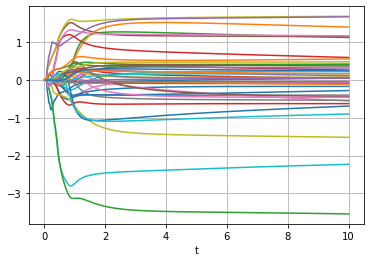

In [70]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [71]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(LL+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [72]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [73]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [74]:
psi = var_ansatz(start_point,psi_0)

In [75]:
psi_ground = eigenvec[:,0]


In [76]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))
psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    
    for i in range(LL+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


(0.94, 0.98)

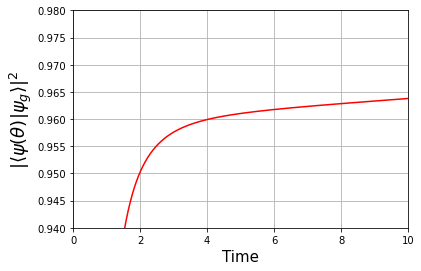

In [80]:
plt.plot(time_domain,expt_value_u, color = "red")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.xlim(0,10)
plt.ylim(0.94,0.98)

#plt.savefig("Imaginary_time_evolution_fidelity_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

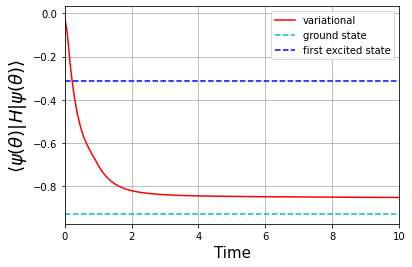

In [78]:
plt.plot(time_domain,energy, color = "red",label = "variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c", label = "ground state")
plt.plot(time_domain,eigenval[1]*np.ones(len(time_domain)), ls = "--", color ="b", label = "first excited state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.xlim(0,10)
plt.legend()
#plt.ylim(0.9,0.95)

#plt.savefig("Imaginary_time_evolution_energy_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

In [79]:
print(expt_value_u[-1])

0.9637895669631082


In [ ]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
